In [26]:
import os
import numpy as np
import pandas as pd

In [27]:
LABELS = {
    0: "aegypti",
    1: "albopictus",
    2: "anopheles",
    3: "culex",
    4: "culiseta",
    5: "japonicus/koreicus"
}

In [28]:
TRAIN_OUTPUT = "./submissions/results_train_1.csv"

train_result = pd.read_csv(TRAIN_OUTPUT).drop(columns=["id"])
train_result.columns

Index(['ImageID', 'LabelName', 'Conf', 'xcenter', 'ycenter', 'bbx_width',
       'bbx_height'],
      dtype='object')

In [29]:
train_true = pd.DataFrame(columns=train_result.columns).drop(columns=["Conf"])
train_true.columns

Index(['ImageID', 'LabelName', 'xcenter', 'ycenter', 'bbx_width',
       'bbx_height'],
      dtype='object')

In [30]:
TRAIN_LABELS_FOLDER = "../data_3/labels/train"

for ImageID in train_result["ImageID"].values:
    label_name = ImageID.replace(".jpeg", ".txt")
    
    label_data = np.loadtxt(os.path.join(TRAIN_LABELS_FOLDER, label_name))

    cls = int(label_data[0])
    xcenter, ycenter, bbx_width, bbx_height = label_data[1:]
    
    new_row = pd.DataFrame({
        "ImageID": [ImageID],
        "LabelName": [cls],
        "xcenter": [xcenter],
        "ycenter": [ycenter],
        "bbx_width": [bbx_width],
        "bbx_height": [bbx_height]
    })
    
    train_true = pd.concat([train_true, new_row], ignore_index=True)

/tmp/ipykernel_88489/1007814175.py:20: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  train_true = pd.concat([train_true, new_row], ignore_index=True)


In [31]:
train_result = train_result.drop(columns=["Conf", "ImageID"])
train_true = train_true.drop(columns=["ImageID"])

In [32]:
assert train_result.shape == train_true.shape

In [33]:
print(train_result.columns)
print(train_true.columns)

Index(['LabelName', 'xcenter', 'ycenter', 'bbx_width', 'bbx_height'], dtype='object')
Index(['LabelName', 'xcenter', 'ycenter', 'bbx_width', 'bbx_height'], dtype='object')


In [34]:
train_result.head()

,LabelName,xcenter,ycenter,bbx_width,bbx_height
0,albopictus,0.541513,0.444457,0.329968,0.214255
1,albopictus,0.543564,0.486536,0.174161,0.243519
2,albopictus,0.324496,0.443159,0.200611,0.324669
3,culex,0.535351,0.501443,0.506525,0.245751
4,culiseta,0.443808,0.378716,0.502185,0.392609


In [35]:
train_true.head()

,LabelName,xcenter,ycenter,bbx_width,bbx_height
0,1,0.539062,0.443590,0.326172,0.204396
1,1,0.550391,0.480794,0.156250,0.210286
2,1,0.326187,0.443475,0.207122,0.322997
3,3,0.539551,0.486813,0.473633,0.265934
4,5,0.433628,0.382919,0.508447,0.375566


In [36]:
LABELS_INVERT = {v: k for k, v in LABELS.items()}

train_result['LabelName'] = train_result['LabelName'].map(LABELS_INVERT)

In [42]:
train_result.head()

train_result = train_result.astype(np.float64)
train_true = train_true.astype(np.float64)

In [44]:
# mAP calculation

def calculate_iou(box1, box2):
    """
    box = [x_center, y_center, width, height]
    """
    
    x1, y1, w1, h1 = box1
    x2, y2, w2, h2 = box2
    
    x1_lt = x1 - w1/2
    y1_lt = y1 - h1/2
    x1_rb = x1 + w1/2
    y1_rb = y1 + h1/2
    
    x2_lt = x2 - w2/2
    y2_lt = y2 - h2/2
    x2_rb = x2 + w2/2
    y2_rb = y2 + h2/2
    
    xA = max(x1_lt, x2_lt)
    yA = max(y1_lt, y2_lt)
    xB = min(x1_rb, x2_rb)
    yB = min(y1_rb, y2_rb)
    
    interArea = max(0, xB - xA) * max(0, yB - yA)
    
    box1Area = w1 * h1
    box2Area = w2 * h2
    
    iou = interArea / (box1Area + box2Area - interArea)
    
    return iou


In [48]:
# calculate confusion matrix 

true_labels = train_true["LabelName"].values
pred_labels = train_result["LabelName"].values

from sklearn.metrics import confusion_matrix

cm = confusion_matrix(true_labels, pred_labels)

In [49]:
cm

array([[   0,   23,    0,    5,    5,    0],
       [   0, 2847,    0,  130,   29,    0],
       [   0,   11,    0,   37,    5,    0],
       [   0,  104,    0, 2848,   20,    0],
       [   0,   92,    0,  271,   48,    0],
       [   0,  198,    0,   47,   30,    0]])

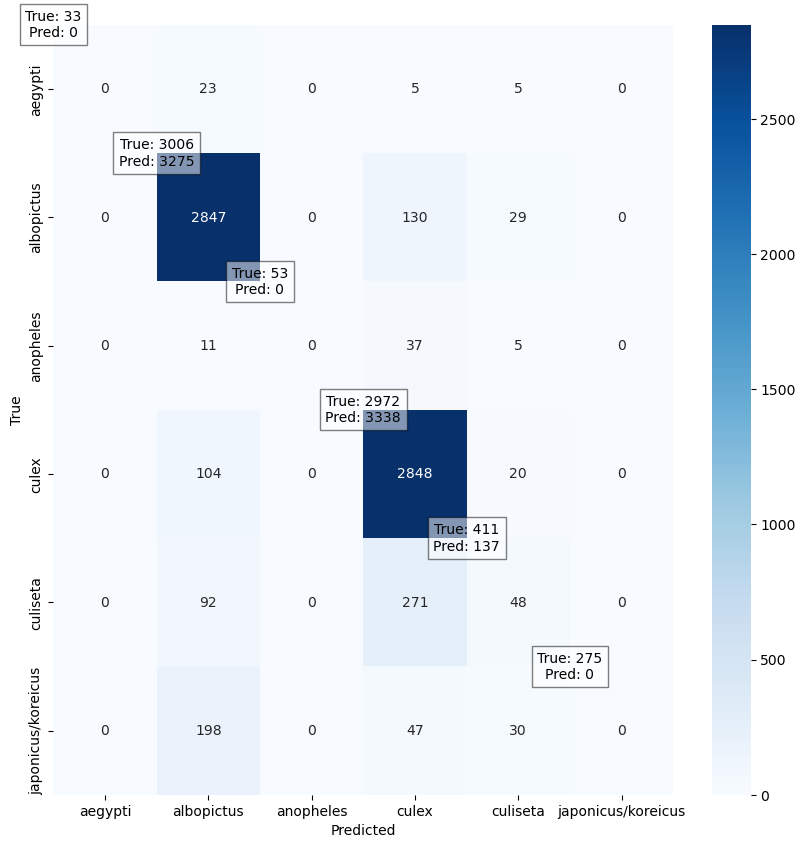

In [55]:
import seaborn as sns

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=LABELS.values(), yticklabels=LABELS.values())

# Print total true and predicted for each class in the side

for i in range(len(LABELS)):
    plt.text(i, i, f"True: {np.sum(cm[i, :])}\nPred: {np.sum(cm[:, i])}", ha='center', va='center', bbox=dict(facecolor='white', alpha=0.5))

plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [54]:
from sklearn.metrics import classification_report

print(classification_report(true_labels, pred_labels, target_names=LABELS.values(), zero_division=0))

                    precision    recall  f1-score   support

           aegypti       0.00      0.00      0.00        33
        albopictus       0.87      0.95      0.91      3006
         anopheles       0.00      0.00      0.00        53
             culex       0.85      0.96      0.90      2972
          culiseta       0.35      0.12      0.18       411
japonicus/koreicus       0.00      0.00      0.00       275

          accuracy                           0.85      6750
         macro avg       0.35      0.34      0.33      6750
      weighted avg       0.78      0.85      0.81      6750

